In [22]:
"""Allgemeine Imports"""
import numpy as np
from numpy.linalg import norm
from scipy.linalg import lu, solve_triangular, qr
import matplotlib.pyplot as plt

## Auftrag 1
$f(x)=\frac{1}{1+x^{2}}$, x element [-5,5]\
Berechnen Sie für n = 6,9,15 über [-5,5] äquidsitant verteile Punkt $(x_k, f_k)$ die natrürliche Splineinterplation $S(x)$\
Stellen Sie jeweils $f(x)$ und $S(x)$ in einem Koordinatensyystem graphisch dar.

In [23]:
def solveSpline(x,xi,yi,mi):
    y = np.zeros_like(x)
    h = xi[1]-xi[0]
    for j in range(xi.shape[0]-1): # loop über die splines-Intervalle!
        if j < xi.shape[0]-2:
            ind = (xi[j]<=x)*(x<xi[j+1])
        else:
            ind = (xi[j]<=x)*(x<=xi[j+1])
        # spline Berechnung auf Intervall (5.2)
        y[ind] = ((xi[j+1]-x[ind])**3*mi[j]+(x[ind]-xi[j])**3*mi[j+1])/(6*h)
        y[ind] += ((xi[j+1]-x[ind])*yi[j]+(x[ind]-xi[j])*yi[j+1])/(h)
        y[ind] -= h/6*((xi[j+1]-x[ind])*mi[j]+(x[ind]-xi[j])*mi[j+1])
    return y

def computeMoments(xi,yi):
    # LR-Zerlegung
    h = xi[1]-xi[0]
    n = xi.size
    
    A = np.diag([4]*(n-2)) + np.diag([1]*(n-3),1) + np.diag([1]*(n-3),-1)
    
    b = (6/(h**2))*(yi[:-2]-2*yi[1:-1]+yi[2:])
    
    P,L,R = lu(A)
    z = solve_triangular(L,P.T@b,lower=True) # Vorwärtseinsetzen
    mi = np.zeros_like(xi)
    mi[1:-1] = solve_triangular(R,z,lower=False) # Rückwärtseinsetzen
    return mi

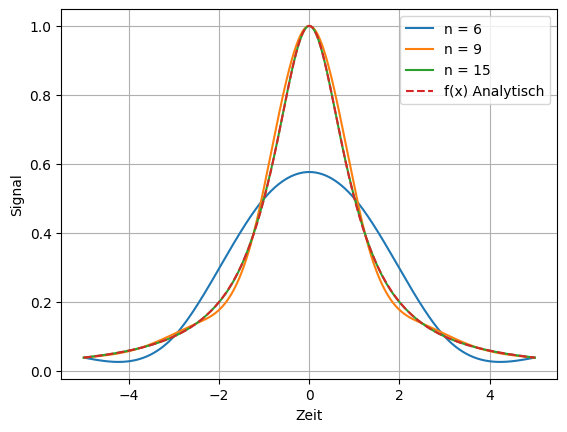

In [24]:
x = np.linspace(-5,5,1000)
x_6 = np.linspace(-5,5,6)
x_9 = np.linspace(-5,5,9)
x_15 = np.linspace(-5,5,15)

def f(x):
    return 1/(1+x**2)

yi_6= f(x_6)
mi_6 = computeMoments(x_6,yi_6)

yi_9= f(x_9)
mi_9 = computeMoments(x_9,yi_9)

yi_15= f(x_15)
mi_15 = computeMoments(x_15,yi_15)

plt.plot(x, solveSpline(x,x_6,yi_6,mi_6), '-', label='n = 6')
plt.plot(x, solveSpline(x,x_9,yi_9,mi_9), '-', label='n = 9')
plt.plot(x, solveSpline(x,x_15,yi_15,mi_15), '-', label='n = 15')
plt.plot(x, f(x), '--', label='f(x) Analytisch')
plt.ylabel('Signal')
plt.xlabel('Zeit')
plt.legend()
plt.grid(True)
plt.show()

## Auftrag 2
Anwendung in der Robotersteuerung:\
Steuerung eines Roboters entlang einer Kurve in der Ebene durch vorgegebene Punkte $P_k = (x_k|y_k)$.
Wir geben uns $n$ Punkte in der $xy$-Ebene in Form einer Liste aus Zeit- und Positionskoordinaten vor.

Zur Robotersteuerung sind auch Positionen nötig, die zwischen den gegebenen Punkten liegen. Aus den vorgegebenen Punkten bestimmen wir Splinefunktionen $S_x(t)$ und $S_y(t)$, die folgendes leisten:
 - zu den vorgegeben Zeitwerten $t_k$ die zugehörigen Positionen $(x_k, y_k)$ liefern,
 - für jeden Zeitpunkt $t ∈ [t_0; t_n]$ eine Position $(x(t), y(t))$ liefern,
 - eine glatte geschlossene Bewegungskurve in der $xy$-Ebene liefern.
Berechnen Sie die Bewegungskurve durch Splineinterpolation mit geeigneten Zusatzbedingungen (natürlich,
periodisch, . . . ?).

In [25]:
def computeMomentsperiodic(xi,yi):
    # LR-Zerlegung
    h = xi[1]-xi[0]
    n = xi.size+1 #Momentenrechung wird um eine Dimension grösser
    
    A = np.diag([4]*(n-2)) + np.diag([1]*(n-3),1) + np.diag([1]*(n-3),-1)
    A += np.diag([1],(n-3))+np.diag([1],-(n-3)) #Obere rechte und undere Linke ecke = 1

    b = np.zeros(n-2)
    b[:-1] = (6/(h**2))*(yi[:-2]-2*yi[1:-1]+yi[2:])
    b[-1] = (6/(h**2))*(yi[-2]-2*yi[0]+yi[1])
    
    P,L,R = lu(A)
    z = solve_triangular(L,P.T@b,lower=True) # Vorwärtseinsetzen
    mi = np.zeros(n-1)
    mi[1:] = solve_triangular(R,z,lower=False) # Rückwärtseinsetzen
    mi[0] = mi[-1]
    return mi

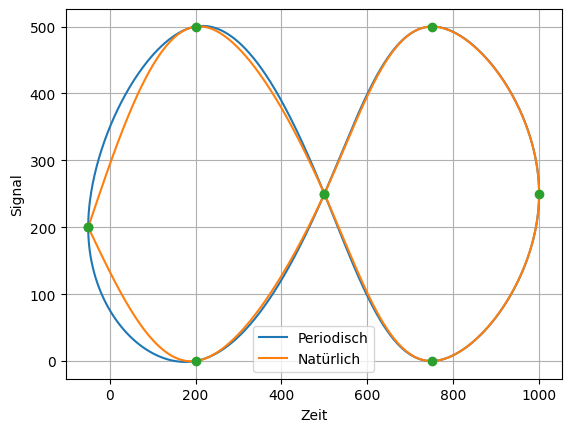

In [26]:
#Periodische Randbeding, Ansatz über Momente, muss zwei splines berechnen

t_p = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16],dtype=float)
x_p = np.array([-50, 200, 500, 750, 1000, 750, 500, 200, -50],dtype=float)
y_p = np.array([200, 0, 250, 500, 250, 0, 250, 500, 200],dtype=float)

t = np.linspace(0,16,1000)
mi_x = computeMomentsperiodic(t_p,x_p)
mi_y = computeMomentsperiodic(t_p,y_p)

mi_natürlich_x = computeMoments(t_p,x_p)
mi_natürlich_y = computeMoments(t_p,y_p)

plt.plot(solveSpline(t,t_p,x_p,mi_x), solveSpline(t,t_p,y_p,mi_y), '-', label='Periodisch')
plt.plot(solveSpline(t,t_p,x_p,mi_natürlich_x), solveSpline(t,t_p,y_p,mi_natürlich_y), '-', label='Natürlich')
plt.plot(x_p,y_p, 'o')
plt.ylabel('Signal')
plt.xlabel('Zeit')
plt.legend()
plt.grid(True)
plt.show()

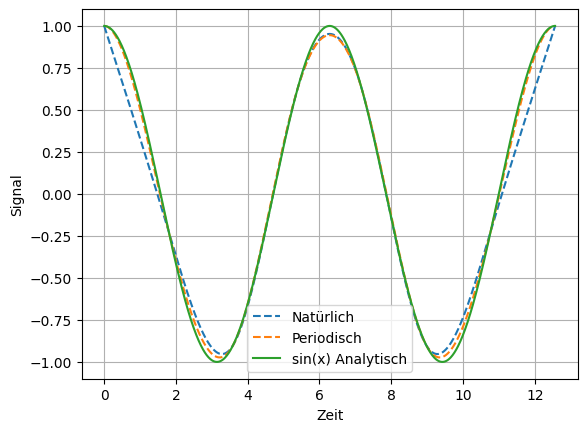

In [27]:
x_analytisch = np.linspace(0,4*np.pi,1000)
x_punkte = np.linspace(0,4*np.pi,8)
y_punkte = np.cos(x_punkte)
mi_punkte_natural = computeMoments(x_punkte, y_punkte)
mi_punkte_periodic = computeMomentsperiodic(x_punkte, y_punkte)

plt.plot(x_analytisch, solveSpline(x_analytisch,x_punkte,y_punkte,mi_punkte_natural), '--', label='Natürlich')
plt.plot(x_analytisch, solveSpline(x_analytisch,x_punkte,y_punkte,mi_punkte_periodic), '--', label='Periodisch')
plt.plot(x_analytisch, np.cos(x_analytisch), '-', label='sin(x) Analytisch')
plt.ylabel('Signal')
plt.xlabel('Zeit')
plt.legend()
plt.grid(True)
plt.show()

# Interpolation of Datapoints


[      0.          -51428.57142857 -274285.71428571  188571.42857143
       0.        ]


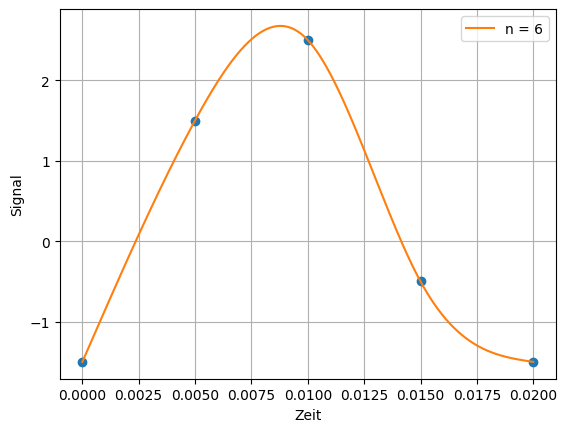

-1.5


In [44]:


x_6 = np.array([0,5,10,15,20])*10**-3
yi_6= np.array([-1.5,1.5,2.5,-0.5,-1.5])
x = np.linspace(0,20,1000)*10**-3

mi_6 = computeMoments(x_6,yi_6)
print(mi_6)

plt.plot(x_6, yi_6, 'o')
y = solveSpline(x,x_6,yi_6,mi_6)
plt.plot(x, y, '-', label='n = 6')

plt.ylabel('Signal')
plt.xlabel('Zeit')
plt.legend()
plt.grid(True)
plt.show()
print(y[int(20/1000*12)])

# Übung 13 2

[ 0  0 -2  4 -3  0  0]


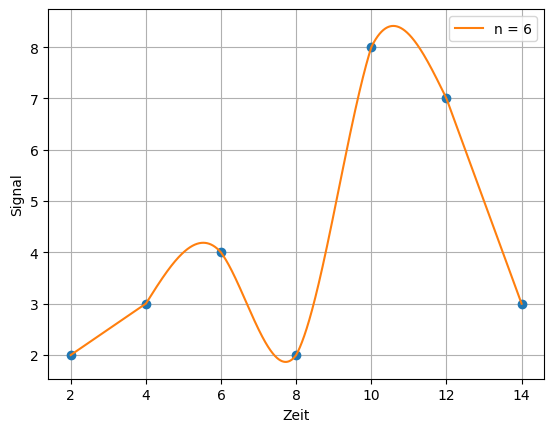

In [31]:
x_6 = np.array([2,4,6,8,10,12,14])
yi_6= np.array([2,3,4,2,8,7,3])
x = np.linspace(2,14,10000)

mi_6 = computeMoments(x_6,yi_6)
print(mi_6)

plt.plot(x_6, yi_6, 'o')
plt.plot(x, solveSpline(x,x_6,yi_6,mi_6), '-', label='n = 6')

plt.ylabel('Signal')
plt.xlabel('Zeit')
plt.legend()
plt.grid(True)
plt.show()